![Qiskit](https://github.com/Qiskit/qiskit-tutorials/raw/115c78962dda85bac29d679063b7d0d0ab1d1ab4/images/qiskit-heading.gif)

# Qcamp - Terra
## IBMQ
### Donny Greenberg, Kevin Krsulich and Thomas Alexander


# Gameplan

* Basics
  * What is Terra?
  * Teleportation
  * QPE a few ways
* Browsing device info
* Tips and tricks
* Learning More, Resources

# What is Terra?

Terra’s core service is the compilation and execution of Quantum circuits for arbitrary backends, and shipping jobs to backends
  * It includes operations for circuit construction, including loading QASM
  * Terra can take the same circuit object and compile and run it on any Quantum hardware or simulator
  * Local simulators are included in Terra and Aer
  * Terra has IBM Q API connections built in - it will send your job to your desired backend and collect the results

Keep in mind:

  * Terra is not a language per se, but more of a large piece of infrastructure.
  * Qiskit is very much a work in progress. It is changing rapidly to converge toward the needs of its users. We welcome development suggestions and help!
  * See our Github (https://github.com/Qiskit/qiskit-terra).

In the future, Terra will include:

  * OpenPulse, pulse level control of IBM Quantum Hardware (find Thomas and ask him about it!)
  * More sophisticated circuit builder interface for constructing and composing large circuits (find Kevin and ask him about it!)

But first, install Terra:

In [13]:
!pip install qiskit

# Structural Elements

Let's start building circuits and get acquainted with Terra.

In [14]:
# Housekeeping: uncomment this to suppress deprecation warnings
import warnings
warnings.filterwarnings('ignore')

In [15]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
import numpy as np

In [16]:
# Create a Quantum Register with 3 qubits
qr = QuantumRegister(3)

# Create a Classical Register with 3 bits
# Only necessary if you want to do measurement!
cr = ClassicalRegister(3)

# Create a Quantum Circuit acting on the qr and cr register
circuit = QuantumCircuit(qr, cr)

# QuantumCircuits are the primary unit of computation in Terra
* QuantumCircuits are backend agnostic
* They contain:
  * name - for referencing the circuit later (e.g. in the results object)
  * data - a list of gates in the circuit
  * regs - the QuantumRegisters and ClassicalRegisters in the gates of the circuit

# Gates! There are many.

Qiskit supports many gates. They are located in the `qiskit/extensions/standard` directory, but are loaded behind the scenes so you don’t need to import them one by one.

Gates are technically objects, but in practice you're likely to use them in the form of static functions on the circuit object. More info on gates [here](https://github.com/Qiskit/qiskit-tutorial/blob/master/qiskit/terra/summary_of_quantum_operations.ipynb).

The basis gateset of the IBM Q devices is `{id, u1, u2, u3, cx}`.

After we add some gates, we can print our circuit's Qasm:

In [17]:
# Hadamard gate on qubit 0
circuit.h(qr[0])

# CNOT (Controlled-NOT) gate from qubit 0 to qubit 1
circuit.cx(qr[0], qr[1])

print(circuit.qasm())

OPENQASM 2.0;
include "qelib1.inc";
qreg q2[3];
creg c2[3];
h q2[0];
cx q2[0],q2[1];



We can also use the CircuitDrawer to visualize the circuit:

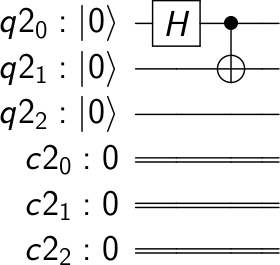

In [18]:
circuit.draw(output='latex')

Now, we have enough to run the circuit. Let's import a backend, in this case a simulator, and run the circuit.

In [19]:
from qiskit import Aer, execute
qasm_backend = Aer.get_backend('qasm_simulator')

job = execute(circuit, qasm_backend)

result = job.result()
result.get_counts(circuit)

{'000': 1024}

Whoops! We forgot to measure. Let's do that.

In [20]:
circuit.measure(qr, cr)
circuit.draw()

In [21]:
job = execute(circuit, qasm_backend)

result = job.result()
result.get_counts(circuit)

{'000': 483, '011': 541}

Note that from version 0.6 onwards, Terra treats the rightmost qubit as qubit 0.

# Qobjs and DAGs

We actually skipped a few steps that happen under the hood during `execute`, but you'll often ignore these for algorithm development. 

Execute calls `compile` to convert the circuit into a `Qobj`, which is a backend-specific object. While doing so, `compile` also calls the `transpiler`, which converts the circuit into a `Directed Acyclic Graph`(`DAG`) of gates, and optimizes the `DAG` for the target execution backend (`DAGs` are much easier to optimize than ciruits). We're going to breeze through these for now.

# Compilation Settings - a good picture of Terra’s robustness

```
def compile(circuits, backend,
            config=None, basis_gates=None, 
            coupling_map=None, initial_layout=None, 
            shots=1024, pass_manager=None, memory=False):
```

* circuits (QuantumCircuit or list[QuantumCircuit]): circuits to compile
* backend (BaseBackend or str): a backend for which to compile
* config (dict): dictionary of parameters (e.g. noise) used by runner - more info [here](https://github.com/Qiskit/qiskit-terra/blob/9149076d16dd98552077e389b21ed2f953d96b2e/src/qasm-simulator-cpp/README.md#config-settings)
* basis_gates (str): comma-separated basis gate set to compile to
* coupling_map (list): coupling map (perhaps custom) representing physical qubit connectivity
* initial_layout (list): user-specified mapping of logical to physical qubits
* shots (int): number of repetitions of each circuit, for sampling
* pass_manager (PassManager): a pass manger for the transpiler pipeline
* memory (bool): if True, per-shot measurement bitstrings are returned as well

# Computational Flow

Let's review our running count of Terra's core objects:
* QuantumRegister, ClassicalRegister
* QuantumCircuit
* Gate
* Backend
* DAG
* Qobj
* Job, result

And the computational flow of Terra is:
* Gates are added to QuantumCircuits
* QuantumCircuits are transpiled into DAGs, DAGs are compiled in Qobjs
* Qobjs are sent to backends
* Backends return results

So far we've run a very vanilla Bell state. Let's do some more interesting things.

In [22]:
qr = QuantumRegister(3)
cr = ClassicalRegister(3)
circuit = QuantumCircuit(qr, cr)
circuit.ry(np.pi/2, qr[0])
circuit.h(qr[1])
circuit.cx(qr[1], qr[2])
circuit.barrier()

circuit.cx(qr[0], qr[1])
circuit.h(qr[0])
circuit.barrier()

circuit.measure(qr[0], cr[0])
circuit.measure(qr[1], cr[1])

circuit.draw()

Qiskit allows conditional gates in simulation, but not on the real quantum hardware (yet).

In [23]:
circuit.z(qr[2]).c_if(cr, 1)
circuit.x(qr[2]).c_if(cr, 2)
circuit.y(qr[2]).c_if(cr, 3) # Note that ZX =iY
circuit.measure(qr[2], cr[2])
circuit.draw()

You can find a more in depth guide to teleportation in Anna Phan's notebook on the topic, [here](https://github.com/Qiskit/qiskit-tutorial/blob/master/community/terra/qis_intro/teleportation_superdensecoding.ipynb).

Let's see what pops out.

In [24]:
job = execute(circuit, qasm_backend)

result = job.result()
result.get_counts(circuit)

{'001': 128,
 '101': 124,
 '110': 132,
 '111': 137,
 '010': 119,
 '000': 138,
 '100': 115,
 '011': 131}

Maybe this isn't accurate enough to tell what we encoded on qubit 1. Let's increase the number of shots.

In [25]:
job = execute(circuit, qasm_backend, shots = 10000)

result = job.result()
result.get_counts(circuit)

{'001': 1205,
 '101': 1224,
 '110': 1289,
 '111': 1219,
 '010': 1315,
 '000': 1245,
 '100': 1208,
 '011': 1295}

Now let's visualize those results as a histogram

In [26]:
from qiskit.tools.visualization import plot_histogram

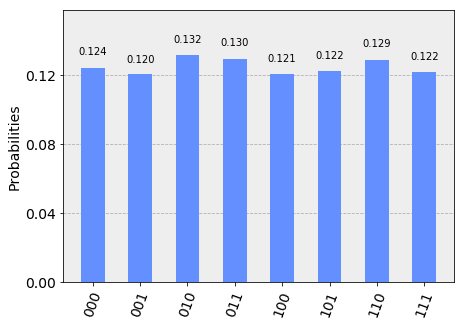

In [27]:
plot_histogram(result.get_counts(circuit))

And now, calculating the percentage of shots with |0> measured on qubit 2 (but qubit 0 in our results).

In [28]:
counts = result.get_counts(circuit)
qubit3_p0 = sum([v for k, v in counts.items() if k[0]=='0'])/10000
qubit3_p0

0.506

Our probability of finding 0 is 50%, which is correct, because Ry(pi/2) should put qubit 0 in the |+> state. 

But how do we know that we're not in the |-> state, or any other state along the equator of the Bloch sphere? Let's use a Hadamard to see whether our phase is correct. We'll need to delete the final measurement and add the Hadamard to do this.

In [29]:
del(circuit.data[-1])
circuit.h(qr[2])
circuit.measure(qr[2], cr[2])
circuit.draw(line_length=200)

In [63]:
shots = 100000
job = execute(circuit, qasm_backend, shots=shots)

result = job.result()
result.get_counts(circuit)
counts = result.get_counts(circuit)
qubit3_p0 = sum([v for k, v in counts.items() if k[0]=='0'])/100000
qubit3_p0

1.0

Looks like our final state is indeed |+>, because our P(|0>) = 100%. 

# Example: Phase Estimation

Let's see if we can work out a small phase estimation function, and sanity check it on simulators before trying it on the quantum hardware. 

- We'll start with a QFT, which comes directly from Terra. 
- We're going to use the Pauli X as our unitary, which simplifies things a lot
- I'll then define a function to give me my circuit

In [31]:
def qft(circ, q, n):
    """n-qubit QFT on q in circ."""
    for j in range(n):
        for k in range(j):
            circ.cu1(np.pi / float(2**(j - k)), q[j], q[k])
        circ.h(q[j])

In [32]:
#Takes in a circuit with an operator on qubit n and appends the qpe circuit
def x_qpe(circ, q, n):
    for i in range(n-1):
        circ.h(q[i])
    for j in range(0, n-1, 2): # Only place a CX^n on every other qubit, because CX^n = I for n even
        circ.cx(q[j], q[n-1])
    circ.barrier()
    qft(circ, q, n-1)

Play around with the ancilla number, the operator, the initial state, etc., see what happens!

In [33]:
# n-1 is the number of ancilla
n = 4
qr = QuantumRegister(n)
cr = ClassicalRegister(n)
circuit = QuantumCircuit(qr, cr)
circuit.rx(np.pi/2, qr[n-1])
circuit.barrier()
x_qpe(circuit, qr, n)

In [34]:
circuit.draw(line_length=200)

Now that we have our basic algorithm, let's start trying to test and validate it in **quantum execution environments**.

# Interlude: Backends

Qiskit offers connectors into execution `providers`, each with several `backends`:

* BasicAer: Terra's built-in suite of pure-python simulators
* Aer: Qiskit's suite of high-performance simulators
* IBMQ: IBM's Quantum devices, and an HPC simulator 

In [35]:
from qiskit import IBMQ, Aer, BasicAer

# Simuators

* qasm_simulator - a shot-based simulator
  * Input: a Qobj and execution config
  * Output: a results object containing a dictionary with basis states and shots per state
    * {‘00’: 425, ‘01’: 267, ‘11’: 90}
  * You can specify a random seed so the probabilistic measurement and noise stays the same

# Simulators
* statevector_simulator - This is the qasm_simulator with a snapshot at the end
  * Returns result object containing a dictionary of basis states with complex amplitudes for each
* unitary_simulator - Returns a matrix of your circuit!
* ibmq_qasm_simulator - a public simulator on an HPC machine run by IBM (Note, this is under the IBMQ `provider`)

# Aer vs BasicAer
- Aer is fast
- BasicAer is slow

* `aer.noise` - includes sophisticated noise models, which you can find more info about [here](https://qiskit.org/documentation/aer/device_noise_simulation.html)
* `pip install qiskit` comes with binaries for many platforms so you shouldn’t need to compile cpp (but if you do, check out the [Terra contributing file on github](https://github.com/Qiskit/qiskit-terra/blob/master/.github/CONTRIBUTING.rst) for make instructions.)

In [36]:
backend = Aer.get_backend("qasm_simulator")
print(backend)

qasm_simulator


## Ok - Back to Phase Estimation:

In [110]:
qasm_backend = Aer.get_backend('qasm_simulator')

Don't forget to measure! Recall that we don't measure our |u> qubit.

In [111]:
circuit.barrier()
for i in range(n-1):
    circuit.measure(qr[i], cr[i])

In [112]:
shots = 10000
job = execute(circuit, qasm_backend, shots = shots)

result = job.result()
counts = result.get_counts(circuit)

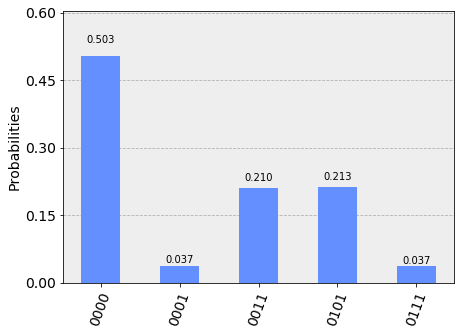

In [113]:
plot_histogram(counts)

We seem to be getting an ok answer, so let's try running on the **Quantum hardware**.

# The IBMQ Provider: Executing on Quantum Hardware


To do this, you'll either get your Q Network API token and URL from the [console](https://q-console.mybluemix.net/) (if you are are a member of the Q Network), or you'll need to get an IBM Q Experience API token from the [Q Experience accounts page](https://quantumexperience.ng.bluemix.net/qx/account/advanced).

In [47]:
# IBMQ.enable_account('<key>')
# uncomment this ^^^ and insert your API key. Add a 'url' argument for Q Network users

# Or you can use:
IBMQ.load_accounts()

print("Available backends:")
IBMQ.backends(filters= lambda b: b.hub is None)

Available backends:


[<IBMQBackend('ibmqx2') from IBMQ()>,
 <IBMQBackend('ibmqx4') from IBMQ()>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ()>,
 <IBMQBackend('ibmq_4_atlantis') from IBMQ()>,
 <IBMQBackend('ibmq_local_test_mock') from IBMQ()>,
 <IBMQBackend('ibmq_qasm_simulator') from IBMQ()>]

In [96]:
q_backend = IBMQ.get_backend('ibmqx4')

## Back again to our circuit:

In [98]:
shots = 8192        # Number of shots to run the program (experiment); maximum is 8192 shots.
job_exp = execute(circuit, q_backend, shots = shots)

In [99]:
# Check the job status
job_exp.status()

<JobStatus.QUEUED: 'job is queued'>

FYI, you can also retrieve an old job by its job_id.

In [40]:
jobID = job_exp.job_id()

print('JOB ID: {}'.format(jobID))

job_get=q_backend.retrieve_job(jobID)
job_get.result().get_counts(circuit)

JOB ID: 5c72d443c426dc0062a3525c


{'0110': 343,
 '0000': 2415,
 '0010': 447,
 '0101': 1604,
 '0100': 1792,
 '0011': 566,
 '0111': 412,
 '0001': 613}

Note that I increase the timeout and wait time considerably - this is often necessary. The defaults can be too short.

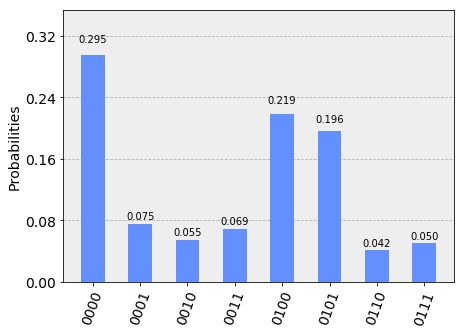

In [41]:
# We recommend increasing the timeout to 30 minutes to avoid timeout errors when the queue is long.
result_real = job_exp.result(timeout=3600, wait=5)
counts = result_real.get_counts(circuit)
plot_histogram(counts)

# Visualizing Devices, and Pulling Device Info

- Terra has some neat built-in Jupyter magics for browsing device information, such as:
    - qubit error
    - job queues for public devices
    - coupling maps

- More info [here](https://github.com/Qiskit/qiskit-tutorials/blob/master/qiskit/jupyter/jupyter_backend_tools.ipynb).

You can view the raw properties data for any backend like this:

In [53]:
q_backend.properties()

BackendProperties(backend_name='ibmq_16_melbourne', backend_version='1.0.0', gates=[Gate(gate='u1', parameters=[Nduv(date=datetime.datetime(2019, 2, 25, 7, 31, 1, tzinfo=tzutc()), name='gate_error', unit='', value=0.0)], qubits=[0]), Gate(gate='u2', parameters=[Nduv(date=datetime.datetime(2019, 2, 25, 7, 31, 1, tzinfo=tzutc()), name='gate_error', unit='', value=0.001657744694001706)], qubits=[0]), Gate(gate='u3', parameters=[Nduv(date=datetime.datetime(2019, 2, 25, 7, 31, 1, tzinfo=tzutc()), name='gate_error', unit='', value=0.003315489388003412)], qubits=[0]), Gate(gate='u1', parameters=[Nduv(date=datetime.datetime(2019, 2, 25, 7, 31, 1, tzinfo=tzutc()), name='gate_error', unit='', value=0.0)], qubits=[1]), Gate(gate='u2', parameters=[Nduv(date=datetime.datetime(2019, 2, 25, 7, 31, 1, tzinfo=tzutc()), name='gate_error', unit='', value=0.007657438332263289)], qubits=[1]), Gate(gate='u3', parameters=[Nduv(date=datetime.datetime(2019, 2, 25, 7, 31, 1, tzinfo=tzutc()), name='gate_error', 

# A Prettier Device Overview

In [54]:
from qiskit.tools.jupyter import *

![backends](https://user-images.githubusercontent.com/8622381/51447753-18c78080-1cef-11e9-8d46-4e8818b5bb57.png)

# Diving into a Specific Backend

In [101]:
%qiskit_backend_monitor q_backend

# Noise Modelling
- The above contains enough information to simulate the approximate noise properties of the device. Chris will talk more about this later.

# Tips and tricks

* Put many circuits into a single execution!
  * Simulators will (generally) execute these in parallel
  * Quantum Hardware does a lot of calibration for each new job, so if you send 100 jobs it will generally take 100x as long as one job with 100 circuits, even if the circuits are completely different!
* Increase your timeout when waiting for results! Default is 30 seconds, better to set to 1800 (30 mins)
  * See notebook above (ctrl-f for 'timeout')
* Use an IDE!! For example Pycharm, VisualStudio, etc. Being able to step through the code is critical!

* Look at the debug log messages. There is a ton of important info in there. See notebook here
  * Even better, save them to a file.

In [ ]:
import logging
logging.getLogger('qiskit').setLevel(logging.DEBUG)

Redirecting logs to a file:

```
# Redirecting debug logs to a file (can't be done in colab):
    loggerc = logging.getLogger('qiskit_aqua_chemistry')
    loggerc.setLevel(logging.DEBUG)
    loggera = logging.getLogger('qiskit_aqua')
    loggera.setLevel(logging.DEBUG)
    loggerq = logging.getLogger('qiskit')
    loggerq.setLevel(logging.DEBUG)
    formatter = logging.Formatter(fmt='%(asctime)s %(levelname)-8s %(message)s', datefmt='%Y-%m-%d %H:%M:%S')
    hdlr = logging.FileHandler(outdir + log_file_name, mode='w')
    hdlr.setFormatter(formatter)
    loggerc.addHandler(hdlr)
    loggera.addHandler(hdlr)
    loggerq.addHandler(hdlr)
    print('\nlog file: {}'.format(outdir + log_file_name))
# <build, execute, etc.>
# close up handlers
    loggerc.removeHandler(hdlr)
    loggera.removeHandler(hdlr)
    loggerq.removeHandler(hdlr)
    hdlr.close()
```

## Learning more

The [qiskit-tutorial](https://github.com/Qiskit/qiskit-tutorial) repo on Github has dozens of thoughtful and sophisticated tutorials. 
- We highly recommend going through both the “[qiskit/](https://github.com/Qiskit/qiskit-tutorial/tree/master/qiskit)” directory and the “[community/](https://github.com/Qiskit/qiskit-tutorial/tree/master/community)” directory. 
- We learn new things every time I look through them, and reference them regularly.
- If you have any questions come find us or one of the other IBM Q members!

# Review - Quantum Algorithm Building Blocks

Four major building blocks of quantum algorithms:

* Quantum Fourier Transform
   * Period-finding and phase↔norm swapping
   * Speedup from $O(2^n)$ to $O(n^2)$
   * E.g. Shor’s algorithm, Quantum Phase Estimation
* Hamiltonian Evolution
   * Applying a Hamiltonian to an initial state over an arbitrary time period
   * Exponential speedup (mostly, with complicated factors)
   * E.g. HHL, QAOA, QPE
* Unstructured Search (Grover’s)
   * Search for a state (string) exhibiting a binary condition (e.g. satisfy my 3SAT problem…)
   * Speedup of O(√n)
* Variational Optimization
   * Prepare a quantum state using a parameterized short circuit, use a classical optimizer to optimize parameters toward some desired quality evaluated on the QC (e.g. binary classification)
   * Speedups vary, usually no guaranteed speedup, but good for NISQ machines
   * E.g. VQE, VSVM, QAOA

# Quantum Fourier Transform

We've used it above and it is straightforward to implement, but it is not very intuitive as a building block, and I recommend the [tutorial dedicated to it](https://github.com/Qiskit/qiskit-tutorial/blob/master/community/terra/qis_adv/fourier_transform.ipynb) by Anna Phan. I also highly recommmend 3Blue1Brown's video on the [continuous fourier transform](https://www.youtube.com/watch?v=spUNpyF58BY).

# Hamiltonian Evolution

This is trickier, we're working on it. For now, the best way to learn about this in Qiskit is in the [Aqua operator class](https://github.com/Qiskit/aqua/blob/master/qiskit_aqua/operator.py#L1119), which includes lots of evolution logic.

# Grover’s Algorithm

Pretty straightforward in Terra. See [this notebook](https://github.com/Qiskit/qiskit-tutorial/blob/master/community/algorithms/grover_algorithm.ipynb) by Giacomo Nannicini and Rudy Raymond.



# Variational Optimization

This also doesn't have a standalone tutorial, but the [Aqua VQE](https://github.com/Qiskit/aqua/blob/master/qiskit_aqua/algorithms/adaptive/vqe/vqe.py) is a straightforward, well engineered example of variational optimization. The [Aqua Variational SVM](https://github.com/Qiskit/aqua/blob/master/qiskit_aqua/algorithms/adaptive/qsvm/qsvm_variational.py) is also a good example.

# Learning More - A Longer Course

[This doc](https://docs.google.com/document/d/1WoUQky2NXdbrdGkxaUA28VE7W3fryTQG6ezn8Fw-l4E/edit) details a longer course to fluency in Quantum Programming.

# Time Permitting: Transpilation and the DAGCircuit

The transpiler is the workhorse of Terra. It’s how we keep circuits backend agnostic and compilable for arbitrary quantum hardware. The transpiler in Terra 0.6 was not transparent or extensible enough for increasingly sophisticated transpilation methods, so we tore it down and rewrote it to be much more robust.

The transpiler now transpiles circuits into circuits, rather than into DAGCircuits. This is much more transparent, and allows the end user to view and understand what individual transpiler passes are doing to their circuit. Here's a sample circuit that won't fit nicely on IBM's hardware (our QPE circuit had nearest neighbor connections, so these qubit remappers won't do much):

In [ ]:
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import BasicSwap, CXCancellation, LookaheadSwap, StochasticSwap
from qiskit.transpiler import transpile
from qiskit.mapper import CouplingMap

In [ ]:
qr = QuantumRegister(7, 'q')
qr = QuantumRegister(7, 'q')
tpl_circuit = QuantumCircuit(qr)
tpl_circuit.h(qr[3])
tpl_circuit.cx(qr[0], qr[6])
tpl_circuit.cx(qr[6], qr[0])
tpl_circuit.cx(qr[0], qr[1])
tpl_circuit.cx(qr[3], qr[1])
tpl_circuit.cx(qr[3], qr[0])
tpl_circuit.draw()

# Swap mapping 
The most naive thing we can do is simply move qubits around greedily with swaps. Let’s see how the BasicSwap pass does here:

In [ ]:
coupling = [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6]]

simulator = BasicAer.get_backend('qasm_simulator')
coupling_map = CouplingMap(couplinglist=coupling)
pass_manager = PassManager()
pass_manager.append([BasicSwap(coupling_map=coupling_map)])
basic_circ = transpile(tpl_circuit, simulator, pass_manager=pass_manager)
basic_circ.draw()

Not great. Let’s try Sven Jandura's LookaheadSwap, submitted for the 2018 QISKit
Developer Challenge. Sven’s swap pass was merged into Terra, and we will have two more passess from other winners of the Qiskit Developer Challenge soon! We’re constructing a diverse set of passes, many user contributed, to meet the wide-ranging needs and mapping scenarios of circuits in the wild.

In [ ]:
pass_manager = PassManager()
pass_manager.append([LookaheadSwap(coupling_map=coupling_map)])
lookahead_circ = transpile(tpl_circuit, simulator, pass_manager=pass_manager)
lookahead_circ.draw()

Better! One more try with the StochasticSwap:

In [ ]:
pass_manager = PassManager()
pass_manager.append([StochasticSwap(coupling_map=coupling_map)])
stoch_circ = transpile(tpl_circuit, simulator, pass_manager=pass_manager)
stoch_circ.draw()

Even better, but still more room to go. Right now this all happens behind the scenes for many users, but we hope that these tools make digging into transpilation much more accessible to those attempting to squeeze as much performance as possible out of their experiments on hardware.

# Transpiling for Real Hardware

Finally, let's see what the default transpiler does to our circuit to be able to run on a real backend. Note that this will include unrolling into the {U, CX} basis, including the swaps.

In [ ]:
tok_circ = transpile(tpl_circuit, backend=q_backend)
tok_circ.draw(line_length=200)

# Modelling Noise in Aer Based on a Device's Properties

Now that you have these properties, you might want to create a noise model for the qasm_simulator which closely resembles this device. A new feature in Aer allows you to do just that. Much of the content below is drawn from [this notebook](https://github.com/Qiskit/qiskit-tutorials/blob/master/qiskit/aer/device_noise_simulation.ipynb).

First, let's pick a backend:

In [56]:
IBMQ.backends(filters= lambda b: b.hub is None)

[<IBMQBackend('ibmqx2') from IBMQ()>,
 <IBMQBackend('ibmqx4') from IBMQ()>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ()>,
 <IBMQBackend('ibmq_4_atlantis') from IBMQ()>,
 <IBMQBackend('ibmq_local_test_mock') from IBMQ()>,
 <IBMQBackend('ibmq_qasm_simulator') from IBMQ()>]

Now, we need to pull the device information:

In [57]:
device = IBMQ.get_backend('ibmq_16_melbourne')
properties = device.properties()
coupling_map = device.configuration().coupling_map

Now, let's construct the device noise model.

Note: The devices don't currently provide gate times, so we will manually provide them for the gates we are interested in using the optional gate_times argument for basic_device_noise_model.

In [58]:
from qiskit.providers.aer import noise

In [59]:
# List of gate times for ibmq_14_melbourne device
# Note that the None parameter for u1, u2, u3 is because gate
# times are the same for all qubits
gate_times = [
    ('u1', None, 0), ('u2', None, 50), ('u3', None, 100),
    ('cx', [1, 0], 678), # I can add gate times for specific couplings, or all couplings
    ('cx', [], 600)
]

# Construct the noise model from backend properties
# and custom gate times
noise_model = noise.device.\
              basic_device_noise_model(properties,
                                       gate_times=gate_times)
print(noise_model)

NoiseModel:
  Instructions with noise: ['measure', 'u2', 'cx', 'u3']
  Specific qubit errors: [('u2', [0]), ('u2', [1]), ('u2', [2]), ('u2', [3]), ('u2', [4]), ('u2', [5]), ('u2', [6]), ('u2', [7]), ('u2', [8]), ('u2', [9]), ('u2', [10]), ('u2', [11]), ('u2', [12]), ('u2', [13]), ('u3', [0]), ('u3', [1]), ('u3', [2]), ('u3', [3]), ('u3', [4]), ('u3', [5]), ('u3', [6]), ('u3', [7]), ('u3', [8]), ('u3', [9]), ('u3', [10]), ('u3', [11]), ('u3', [12]), ('u3', [13]), ('cx', [1, 0]), ('cx', [1, 2]), ('cx', [2, 3]), ('cx', [4, 3]), ('cx', [4, 10]), ('cx', [5, 4]), ('cx', [5, 6]), ('cx', [5, 9]), ('cx', [6, 8]), ('cx', [7, 8]), ('cx', [9, 8]), ('cx', [9, 10]), ('cx', [11, 3]), ('cx', [11, 10]), ('cx', [11, 12]), ('cx', [12, 2]), ('cx', [13, 1]), ('cx', [13, 12]), ('measure', [0]), ('measure', [1]), ('measure', [2]), ('measure', [3]), ('measure', [4]), ('measure', [5]), ('measure', [6]), ('measure', [7]), ('measure', [8]), ('measure', [9]), ('measure', [10]), ('measure', [11]), ('measure', [12]

Now, let's use this model to simulate our QPE circuit. Note, this can take a few minutes to run.

In [ ]:
shots = 1000
basis_gates = noise_model.basis_gates

# Select the QasmSimulator from the Aer provider
simulator = Aer.get_backend('qasm_simulator')

# Execute noisy simulation and get counts
result_noise = execute(circuit, simulator, 
                       shots=shots,
                       noise_model=noise_model,
                       coupling_map=coupling_map,
                       basis_gates=basis_gates).result()
counts_noise = result_noise.get_counts(circuit)
plot_histogram(counts_noise, title="Counts for QPE circuit with depolarizing noise model")

In [ ]:
# And now our phase estimate:
angles = np.array([v*int(k, 2) for k, v in counts_noise.items()]) / shots / 2**(n-1)
res = 2*sum(angles)
np.around(res, decimals=5)

This is actually worse than we get from the device! More tuning to do here.